In [10]:
# Build insurance price prediction model using RF and XGboost. Check which model gives best results.
# Dataset insurance.csv 

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Missing values in each column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Random Forest Regressor - MSE: 21309334.56, R^2: 0.85

XGBoost Regressor - MSE: 24090928.76, R^2: 0.84

Random Forest performed better.



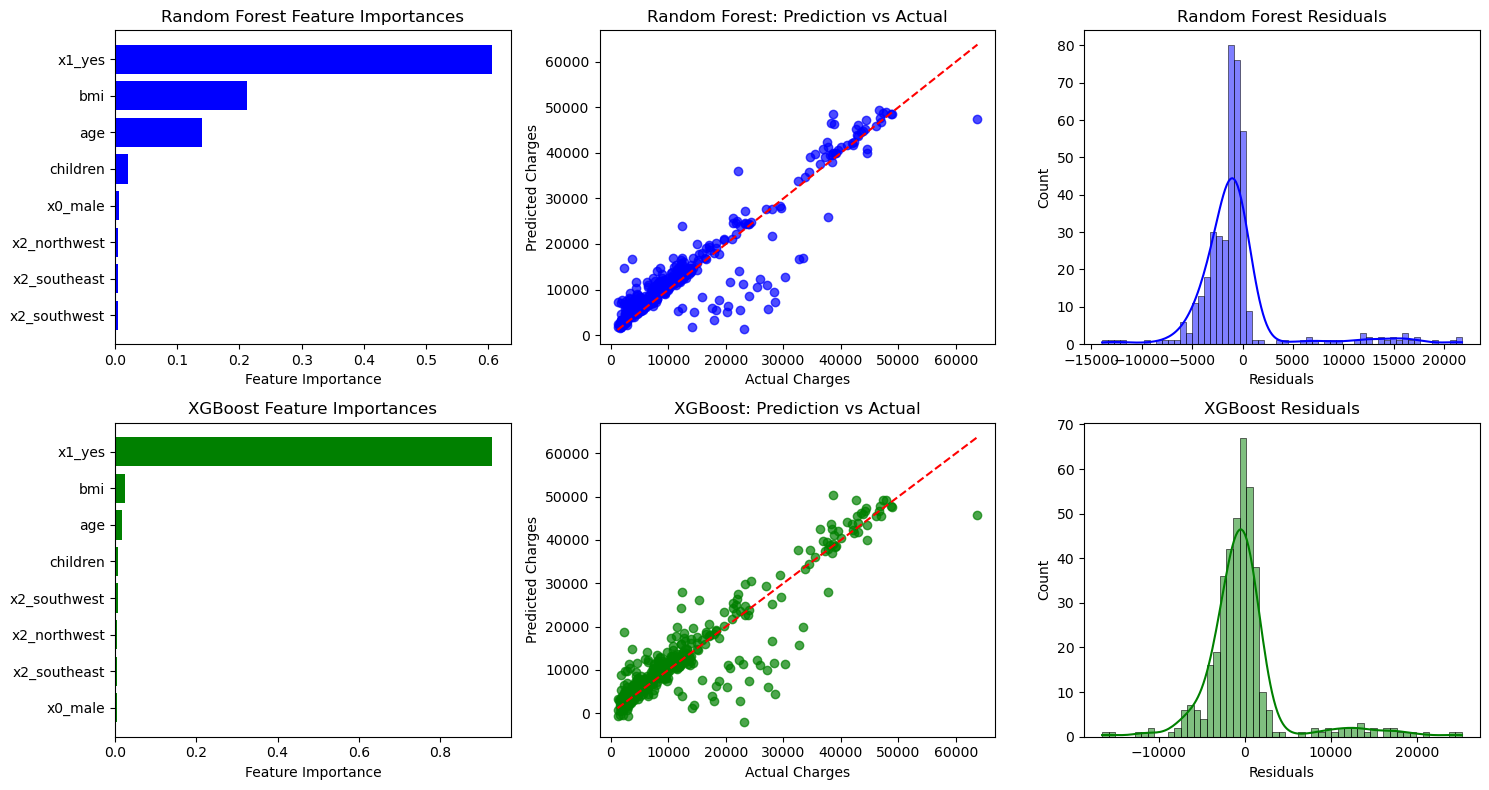

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Loading the dataset
data = pd.read_csv("/Users/diboshbaruah/Desktop/Python/insurance.csv")
print(data.head())
print()

# Inspecting missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)
print()

# Defining features and target variable
X = data.drop(columns='charges')
y = data['charges']

# Defining categorical and numerical features
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

# Defining preprocessing for numerical and categorical features
# Imputed missing values with mean
# Standardized numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

# Imputed missing values with most frequent value
# Using One-hot encode on categorical features, we drop first to avoid multi-collinearity
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(drop='first'))  
])

# We combine preprocessing steps into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining pipelines for both models
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, random_state=42))
])

# Training Random Forest model
rf_pipeline.fit(X_train, y_train)
rf_y_pred = rf_pipeline.predict(X_test)

# Training XGBoost model
xgb_pipeline.fit(X_train, y_train)
xgb_y_pred = xgb_pipeline.predict(X_test)

# Evaluated Random Forest model
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f"Random Forest Regressor - MSE: {rf_mse:.2f}, R^2: {rf_r2:.2f}")
print()

# Evaluated XGBoost model
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)
print(f"XGBoost Regressor - MSE: {xgb_mse:.2f}, R^2: {xgb_r2:.2f}")
print()

# Comparing the results
if rf_r2 > xgb_r2:
    print("Random Forest performed better.")
else:
    print("XGBoost performed better.")
print()

# Plotting the results to have to effectively visualise the performance
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Plotting Feature Importances for Random Forest
rf_model = rf_pipeline.named_steps['model']
importances = rf_model.feature_importances_
feature_names = numerical_features + list(rf_pipeline.named_steps['preprocessor']
                                          .named_transformers_['cat']
                                          .named_steps['onehot']
                                          .get_feature_names_out())
sorted_indices = importances.argsort()
axs[0, 0].barh(range(len(importances)), importances[sorted_indices], align='center', color='blue')
axs[0, 0].set_yticks(range(len(importances)))
axs[0, 0].set_yticklabels([feature_names[i] for i in sorted_indices])
axs[0, 0].set_xlabel('Feature Importance')
axs[0, 0].set_title('Random Forest Feature Importances')

# Plotting Prediction vs. Actual for Random Forest
axs[0, 1].scatter(y_test, rf_y_pred, color='blue', alpha=0.7)
axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axs[0, 1].set_xlabel('Actual Charges')
axs[0, 1].set_ylabel('Predicted Charges')
axs[0, 1].set_title('Random Forest: Prediction vs Actual')

# Plotting Residuals for Random Forest
residuals_rf = y_test - rf_y_pred
sns.histplot(residuals_rf, kde=True, color='blue', ax=axs[0, 2])
axs[0, 2].set_xlabel('Residuals')
axs[0, 2].set_title('Random Forest Residuals')

# Plotting Feature Importances for XGBoost
xgb_model = xgb_pipeline.named_steps['model']
xgb_importances = xgb_model.feature_importances_
sorted_indices = xgb_importances.argsort()
axs[1, 0].barh(range(len(xgb_importances)), xgb_importances[sorted_indices], align='center', color='green')
axs[1, 0].set_yticks(range(len(xgb_importances)))
axs[1, 0].set_yticklabels([feature_names[i] for i in sorted_indices])
axs[1, 0].set_xlabel('Feature Importance')
axs[1, 0].set_title('XGBoost Feature Importances')

# Plotting Prediction vs. Actual for XGBoost
axs[1, 1].scatter(y_test, xgb_y_pred, color='green', alpha=0.7)
axs[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axs[1, 1].set_xlabel('Actual Charges')
axs[1, 1].set_ylabel('Predicted Charges')
axs[1, 1].set_title('XGBoost: Prediction vs Actual')

# Plotting Residuals for XGBoost
residuals_xgb = y_test - xgb_y_pred
sns.histplot(residuals_xgb, kde=True, color='green', ax=axs[1, 2])
axs[1, 2].set_xlabel('Residuals')
axs[1, 2].set_title('XGBoost Residuals')

# Adjusting layout to fit all plots nicely
plt.tight_layout()
plt.show()

